In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import random
from time import sleep

In [2]:
h1 = {
'Cookie': 'bid=pWHRXljqlnw; _pk_id.100001.4cf6=1889b80fc0472f29.1700409010.; __utmc=30149280; __utmz=30149280.1700409010.1.1.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); __utmc=223695111; __utmz=223695111.1700409010.1.1.utmcsr=google|utmccn=(organic)|utmcmd=organic|utmctr=(not%20provided); _ga=GA1.1.5521471.1700409010; ll="118282"; __utma=30149280.5521471.1700409010.1700409010.1700411523.2; __utma=223695111.1586942768.1700409010.1700409010.1700411523.2; _vwo_uuid_v2=D6D254F941FF811FF3C5BC45942B6A3E4|40c2965b4880f3c13ff94c0a7cdc0e98; _ga_RXNMP372GL=GS1.1.1700413503.2.0.1700413503.60.0.0; _pk_ref.100001.4cf6=%5B%22%22%2C%22%22%2C1700552142%2C%22https%3A%2F%2Fwww.google.com%2F%22%5D; _pk_ses.100001.4cf6=1; ap_v=0,6.0; dbcl2="276019366:j+LEQsNs20s"; ck=_dp9; frodotk_db="98c409fbb250fd78ca4c1df316f2f868"; push_noty_num=0; push_doumail_num=0',
'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
'Accept-Encoding': 'gzip, deflate',
'Host': 'movie.douban.com',
'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.4 Safari/605.1.15',
'Accept-Language': 'zh-CN,zh-Hans;q=0.9',
'Connection': 'keep-alive'
}

In [3]:
ip_list = []

with open('proxy.txt', 'r') as f:
    for line in f.readlines():
        ip_list.append(line.strip())

#获取ip代理
def getip():
    proxy= ip_list[random.randint(0,len(ip_list)-1)]
    proxy = proxy.replace("\n","")
    proxies={
        'http':'http://'+str(proxy),
        #'https':'https://'+str(proxy),
    }
    return proxies

In [4]:
def trans_star(v_str):
    v_str = v_str[0]
    if v_str == 'allstar10':
        return '1'
    elif v_str == 'allstar20':
        return '2'
    elif v_str == 'allstar30':
        return '3'
    elif v_str == 'allstar40':
        return '4'
    elif v_str == 'allstar50':
        return '5'
    else:
        return 'NaN'

In [5]:
def get_short(movie_url, max_page, data_path, file_name):
    df = pd.DataFrame()
    path =data_path + file_name + '.csv'
    if os.path.exists(path):
        print("file exists")
        return 0
    for i in range(0, max_page):
        url = movie_url + 'comments?start=' + str(i*20) + '&limit=20&status=P&sort=new_score'
        res = requests.get(url, headers=h1, verify=False, proxies=getip())
        soup = BeautifulSoup(res.text, 'html.parser')
        user_names = soup.find_all('span', class_='comment-info')
        user_names = [i.find('a').text for i in user_names]
        stars = soup.find_all('span', class_='comment-info')
        stars = [i.find_all('span')[1]['class'] for i in stars]
        stars = [trans_star(i) for i in stars]
        comment_times = soup.find_all('span', class_='comment-time')
        comment_times = [i.text.strip() for i in comment_times]
        geo_ips = soup.find_all('span', class_='comment-location')
        geo_ips = [i.text for i in geo_ips]
        votes = soup.find_all('span', class_='votes vote-count')
        votes = [i.text for i in votes]
        shorts = soup.find_all('span', class_='short')
        shorts = [i.text for i in shorts]
        shorts = [i.replace(',', '，').replace(' ', '').replace('\n', '').replace('\r', '') for i in shorts]

        pd_data = {'user_name': user_names, 'star': stars, 'comment_time': comment_times, 'geo_ip': geo_ips, 'vote': votes, 'short': shorts}
        df = pd.concat([df, pd.DataFrame(pd_data)], axis=0)
        print('Page ' + str(i+1) + ' is done!')

    if len(df) < 10:
        print('No data!')
        return 1

    df.to_csv(path, index=False)
    return 0

In [6]:
#test
movie_url = 'https://movie.douban.com/subject/35267224/'
max_page = 2
data_path = './data/'
file_name = 'test'
get_short(movie_url, max_page, data_path, file_name)

file exists


0

In [8]:
# search movies by name
name = '阿凡达'
movie_list = pd.read_csv('../analysis/MovieDouban250.csv')
# each line as a movie, convert to list of dict
movie_list = movie_list.to_dict('records')

for movie in movie_list:
    if name in movie['电影名称']:
        print(movie)


{'Unnamed: 0': 71, '电影名称': '阿凡达\xa0/\xa0Avatar\xa0/\xa0', '电影链接': 'https://movie.douban.com/subject/1652587/', '电影评分': 8.8, '评分人数': 1441297, '导演': '导演: 詹姆斯·卡梅隆 James Cameron', '主演': '主演: 萨姆·沃辛顿 Sam Worthington ...', '上映年份': '2009', '国家': '美国', '类型': '动作 科幻 冒险'}


In [9]:
# search movies by id
id = 71
df = pd.DataFrame()
for movie in movie_list:
    if id == movie['Unnamed: 0']:
        file_name = movie['电影名称'].replace(' ', '').split('/')[0].replace('\xa0', '')
if os.path.exists('./data/' + file_name + '.csv'):
    print('file exists!')
    df = pd.read_csv('./data/' + file_name + '.csv')
else:
    print('file not exists!')
    get_short(movie['电影链接'], 30, './data/', file_name)
    df = pd.read_csv('./data/' + file_name + '.csv')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path  
from PIL import Image  
from wordcloud import WordCloud, ImageColorGenerator  
import jieba
from collections import Counter


file exists!


In [10]:
df_star = df.groupby(['star'])['star'].count()
df_star

star
1.0      4
2.0     16
3.0     69
4.0    164
5.0    331
Name: star, dtype: int64

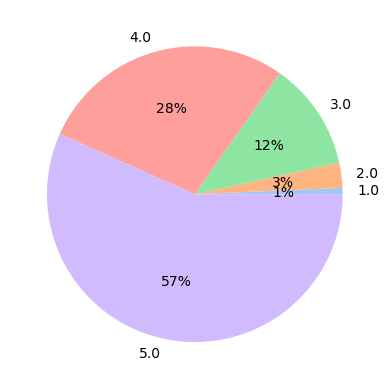

In [11]:
colors = sns.color_palette('pastel')[0:5]
plt.pie(df_star, labels = df_star.index.tolist(), colors = colors, autopct='%.0f%%')
plt.show()

In [12]:
df_date = pd.to_datetime(df['comment_time']).dt.strftime('%Y-%m')
df_date = df_date.groupby(df_date).count()
df_date

comment_time
2009-12     44
2010-01    144
2010-02     49
2010-03     16
2010-04     10
          ... 
2022-09      2
2022-10      3
2022-11      1
2022-12     14
2023-01      1
Name: comment_time, Length: 84, dtype: int64

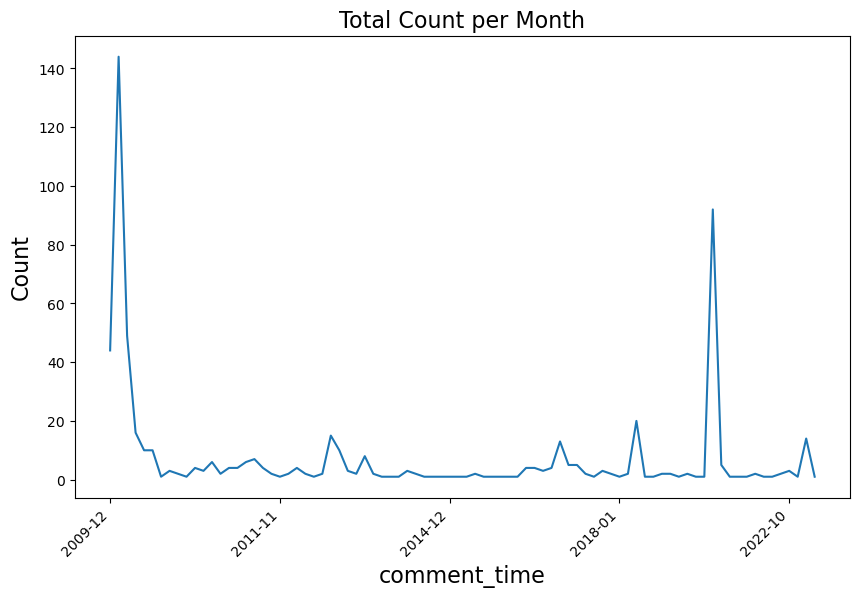

In [13]:

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Total Count per Month', fontsize=16)
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
df_date.plot(kind='line', ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()


c:\Users\shaoh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\shaoh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\shaoh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\shaoh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

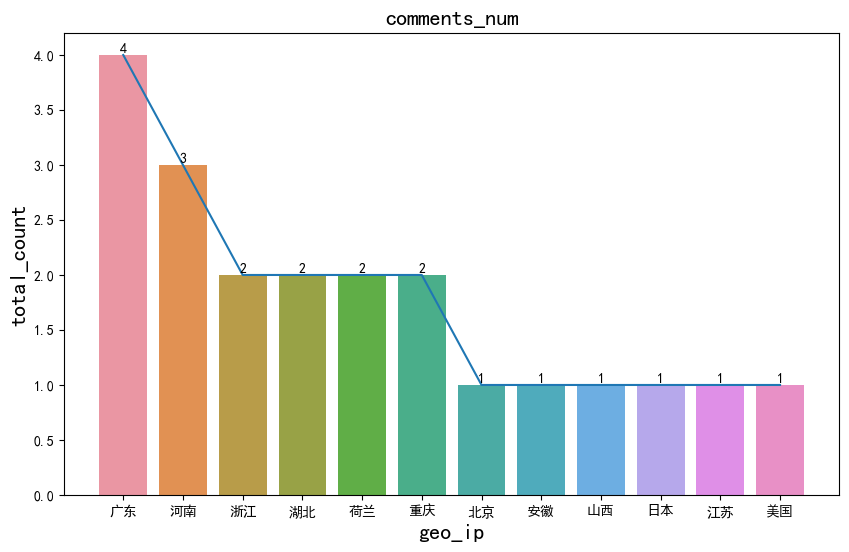

In [14]:
plt.rcParams['font.sans-serif']=['SimHei']
geo_ips = df.groupby(['geo_ip'])['geo_ip'].count().sort_values(ascending=False)
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('comments_num', fontsize=16)
ax1.set_xlabel('geo_ips', fontsize=16)
ax1.set_ylabel('total_count', fontsize=16)
ax1 = sns.barplot(x=geo_ips.index, y = list(geo_ips))
ax1.tick_params(axis='y')
ax1.bar_label(ax1.containers[0])
ax2 = sns.lineplot(x=geo_ips.index, y = list(geo_ips))
ax2.tick_params(axis='y')

In [15]:
stopwords = set()
content = [line.strip() for line in open('../analysis/cn_stopwords.txt','r').readlines()]
stopwords.update(content)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\shaoh\AppData\Local\Temp\jieba.cache
Loading model cost 1.052 seconds.
Prefix dict has been built successfully.


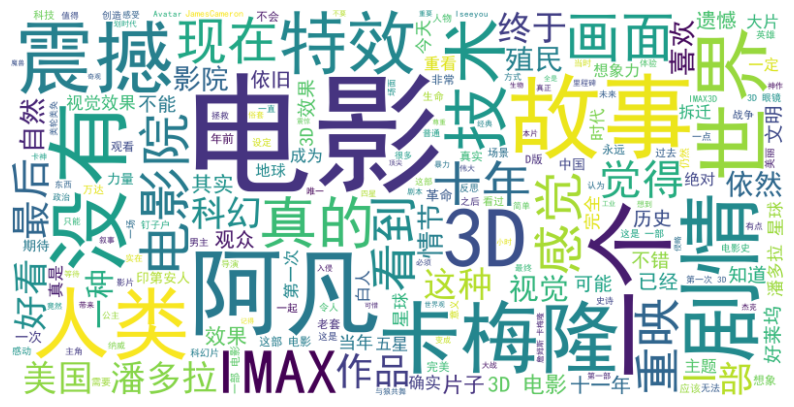

In [16]:
# Combine all shorts into a single string
all_shorts = ' '.join(df['short'])
words = jieba.cut(all_shorts)
words = [word for word in words if len(word) > 1]
words = [word for word in words if word not in stopwords]
words = ' '.join(words)

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, font_path='C:\Windows\Fonts\simhei.ttf').generate(words)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Sentiment 

In [17]:
from cnsenti import Sentiment

In [18]:
df_senti = df.copy()
df_senti = df_senti[['user_name','short']]

senti = Sentiment()

# calculate sentiment for each short
def get_sentiment(short):
    return senti.sentiment_count(short)

df_senti['sentiment'] = df_senti['short'].apply(get_sentiment)
df_senti['sentiment'] = df_senti['sentiment'].apply(lambda x: 'positive' if x['pos'] > x['neg'] else 'negative' if x['pos'] < x['neg'] else 'neutral')

df_senti.head()

,user_name,short,sentiment
0,prost,印第安在白人领导下的反白人入侵战争，可惜史实与此相反,negative
1,RKO,我整个人都潘多拉了,neutral
2,皮革业,JamesCameron闭上眼，全是电影的明天。,neutral
3,荔枝超人,已经不是在看电影了，是在比谁Wow的次数多，眨眼次数少。,negative
4,Menphis,钉子户大战城管in3D,neutral


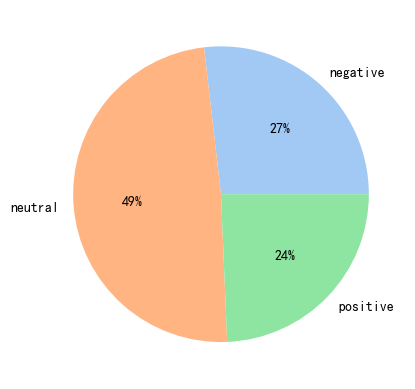

In [19]:
colors = sns.color_palette('pastel')[0:5]
plt.pie(df_senti.groupby(['sentiment'])['sentiment'].count(), labels = df_senti.groupby(['sentiment'])['sentiment'].count().index.tolist(), colors = colors, autopct='%.0f%%')
plt.show()